In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from glob import glob
from scipy import interpolate
import time

In [15]:
def is_in_notebook():
    import sys
    return 'ipykernel' in sys.modules

def clear_output():
    """
    clear output for both jupyter notebook and the console
    """
    import os
    os.system('cls' if os.name == 'nt' else 'clear')
    if is_in_notebook():
        from IPython.display import clear_output as clear
        clear()
        
print('bbb')
clear_output()

In [16]:
def light_curve(lc_dir,look=False):
    data = np.genfromtxt(lc_dir,names="time,flux,et,ef")
    good = (data['ef'] == 0)
    time_diff = data['time'][good][1:] - data['time'][good][:-1]
    
    if (np.max(time_diff) < 10):
        error_point = np.argmax(time_diff)

        time = np.append(data['time'][good][15:error_point-10],data['time'][good][error_point+10:-15])
        flux = np.append(data['flux'][good][15:error_point-10],data['flux'][good][error_point+10:-15])
        et = np.append(data['et'][good][15:error_point-10],data['et'][good][error_point+10:-15])

        norm_flux = (flux - np.median(flux))/(np.max(flux) - np.min(flux))
        norm_et = et / np.abs(np.max(flux) - np.min(flux))

        if look == True:
            plt.figure(figsize=(10,5))
            plt.plot(time,norm_flux,'c')
            plt.xlabel('time');plt.ylabel('flux')
            plt.show()
        else:
            None
        
        w = norm_flux < 0.3
        return time[w],norm_flux[w],norm_et[w]

    else:
        return "bad_data","bad_data","bad_data"


def mulit_light_curve(lc_dir,look=False):
    time = []; flux = []; et = []
    size = 0
    for i in range(10):
        test_dir = lc_dir[:-9] + "0%s" %i + "_LC.txt"
        if os.path.exists(test_dir) == True:
            t,f,e = light_curve(test_dir)
            if t == 'bad_data':
                None
            else:
                time.extend(t)
                flux.extend(f)
                et.extend(e)
                size += 1
        else:
            None

    for i in range(10):
        test_dir = lc_dir[:-9] + "1%s" %i + "_LC.txt"
        if os.path.exists(test_dir) == True:
            t,f,e = light_curve(test_dir)
            if t == 'bad_data':
                None
            else:
                time.extend(t)
                flux.extend(f)
                et.extend(e)
                size += 1
        else:
            None
            
    if size > 0:
        if look == True:
            plt.figure(figsize=(5*size,5))
            plt.plot(time,flux,'c')
            plt.plot(time,flux,'r.')
            plt.xlabel('time');plt.ylabel('flux')
            plt.grid()
            plt.show()
        else:
            None
    else:
        None

    return time, flux, et

In [17]:
def Phase_cycle(t,P,T_0):
    T_diff = np.array(t) - T_0
    I = np.floor(T_diff/P)
    phi = (T_diff/P) - I
    return phi, I #phase and cycle


def sing_dc_func(guess_P,time,norm_flux,norm_et,look=False):
    phi, I = Phase_cycle(time, guess_P, time[0])
    phase_flux = np.stack((phi,norm_flux),axis=-1)
    phase_flux = np.array(sorted(phase_flux,key=lambda x:x[0]))
    phase = phase_flux[:,0]
    flux = phase_flux[:,1]

    if look == True:
        plt.figure(figsize=(10,7))
        plt.plot(phase,flux,'c-')
        plt.plot(phase,flux,'r.')
        plt.xlabel('phase');plt.ylabel('flux')
#         plt.savefig('/Users/laote/sdsu/Research/binary/curve_bin/Binary_period/%s_P_%.3f.png'\
#                     %(lc_dir[-28:-7],guess_P))
        plt.show()        
    
    S = np.fabs(flux[-1] - flux[0]) + np.sum(np.fabs(flux[1:] - flux[:-1]))
    return S/47.-2.,phase,flux

def find_period_SL(datadir,period,bins=10000,look=False):
    st = time.time()
    t,norm_flux,norm_et = mulit_light_curve(datadir)
    
    dc = []
    guess_p = np.linspace(period*0.7,period*1.3,bins)
    for gp in guess_p:
        S,phase,flux = sing_dc_func(gp,t,norm_flux,norm_et)
        dc.append(S)
    mintomax = np.argsort(dc)
    true_p = guess_p[mintomax[0]]
    true_eccp = np.abs(guess_p[mintomax[0]] - guess_p[mintomax[1]])

    S,phase,flux = sing_dc_func(true_p,t,norm_flux,norm_et)
    
    running_time = time.time()-st
    
    if look == True:
        plt.figure(figsize = (10,5))
        plt.subplot(121)
        plt.title('period = %.4f±%.4f days' %(true_p,true_eccp))
        plt.plot(phase,flux,'c-')
        plt.plot(phase,flux,'r.')

        plt.subplot(122)
        plt.title('%s running time = %.4f sec'%(datadir[-28:-7],running_time))
        plt.plot(guess_p,dc)
        plt.show()

    return round(true_p,5),round(true_eccp,5)


def folding(datadir,period,look=False):
    t,norm_flux,norm_et = mulit_light_curve(datadir)
    S,phase,flux = sing_dc_func(period,t,norm_flux,norm_et)
    if look == True:
        plt.figure(figsize = (10,5))
#         plt.subplot(121)
        plt.title('period = %.4f days' %(period))
        plt.plot(phase,flux,'c-')
        plt.plot(phase,flux,'r.')
        plt.show()

    return datadir[-28:-14], period

In [18]:
binary_period = np.genfromtxt('/Users/laote/sdsu/Research/binary/curve_bin/800k_period_v3.txt',dtype=str,skip_header=1)
tic_name = binary_period[:,0]
period = binary_period[:,1].astype(float)
eperiod = binary_period[:,2].astype(float)
first_eci = binary_period[:,3].astype(float)

In [19]:
sort800 =  glob("/Users/laote/sdsu/Research/binary/curve_bin/800000_Curve_binary/*.txt")
bbb = []
ccc = []
for a in sort800:
    if a[-28:-14] in tic_name:
        if a[-28:-14] not in ccc:
            bbb.append(a)
        ccc.append(a[-28:-14])
        
len(bbb)

0

In [20]:
def see_period(datadir):
    data = np.genfromtxt(datadir,names="time,flux,et,ef")
    use = (data['ef'] == 0)

    time_diff = data['time'][use][1:] - data['time'][use][:-1]
    error_point = np.argmax(time_diff)
    
    Time = np.append(data['time'][use][5:error_point-5],data['time'][use][error_point+5:-5])
    flux = np.append(data['flux'][use][5:error_point-5],data['flux'][use][error_point+5:-5])

    med = np.median(flux) 
    std = np.std(flux)
    
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(Time,flux/med,'c')
    plt.plot(Time,flux/med,'r.')
    plt.subplot(122)
    plt.plot(Time,flux,'c')
    plt.plot(Time,flux,'r.')
    plt.show()

In [10]:
# dirname = '/Users/laote/sdsu/Research/binary/curve_bin/Binary_ck/tic00141685465_SEC011_LC.txt'

# folding(dirname,7.8086,look=True)
# see_period(dirname)
# t13,f13,ef13 = mulit_light_curve(dirname,look=True)

# fail

In [11]:
# dirname = '/Users/laote/sdsu/Research/binary/curve_bin/Binary_ck/tic00141809359_SEC006_LC.txt'

# folding(dirname,12.1562,look=True)
# see_period(dirname)
# t13,f13,ef13 = mulit_light_curve(dirname,look=True)

# fail

In [12]:
# dirname = '/Users/laote/sdsu/Research/binary/curve_bin/Binary_ck/tic00307488184_SEC005_LC.txt'

# see_period(dirname)
# t13,f13,ef13 = mulit_light_curve(dirname,look=True)

# fail

In [13]:
# dirname = '/Users/laote/sdsu/Research/binary/curve_bin/800000_Curve_binary/tic00033831424_SEC005_LC.txt'

# folding(dirname,10.2387,look=True)
# see_period(dirname)
# t13,f13,ef13 = mulit_light_curve(dirname,look=True)

# fail

In [14]:
# dirname = '/Users/laote/sdsu/Research/binary/curve_bin/800000_Curve_binary/tic00141685465_SEC005_LC.txt'
# dirname = '/Users/laote/sdsu/Research/binary/curve_bin/800000_Curve_binary/tic00141685465_SEC009_LC.txt'


# folding(dirname,7.8086,look=True)
# see_period(dirname)
# t13,f13,ef13 = mulit_light_curve(dirname,look=True)

# fail

In [9]:
# dirname = '/Users/laote/sdsu/Research/binary/curve_bin/800000_Curve_binary/tic00149971575_SEC005_LC.txt'

# folding(dirname,9.2636,look=True)
# see_period(dirname)
# t13,f13,ef13 = mulit_light_curve(dirname,look=True)

In [10]:
# dirname = '/Users/laote/sdsu/Research/binary/curve_bin/800000_Curve_binary/tic00150430842_SEC005_LC.txt'

# folding(dirname,15.0683,look=True)
# see_period(dirname)
# t13,f13,ef13 = mulit_light_curve(dirname,look=True)

In [11]:
# dirname = '/Users/laote/sdsu/Research/binary/curve_bin/800000_Curve_binary/tic00260128333_SEC010_LC.txt'


# see_period(dirname)
# t13,f13,ef13 = mulit_light_curve(dirname,look=True)

# # already have

In [12]:
# dirname = '/Users/laote/sdsu/Research/binary/curve_bin/800000_Curve_binary/tic00349572805_SEC002_LC.txt'

# folding(dirname,5.4091,look=True)
# see_period(dirname)
# t13,f13,ef13 = mulit_light_curve(dirname,look=True)

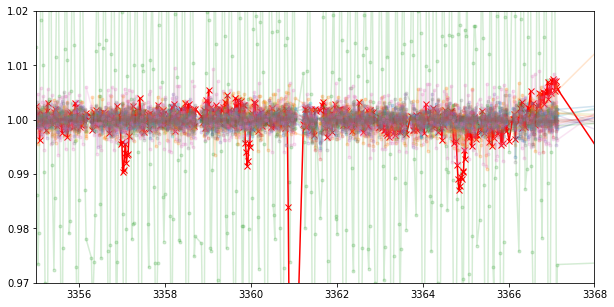

['/Users/laote/sdsu/Research/binary/curve_bin/Binary_ck/tic00041087815_SEC002_LC.txt',
 '/Users/laote/sdsu/Research/binary/curve_bin/Binary_ck/tic00041087860_SEC002_LC.txt',
 '/Users/laote/sdsu/Research/binary/curve_bin/Binary_ck/tic00041087940_SEC002_LC.txt',
 '/Users/laote/sdsu/Research/binary/curve_bin/Binary_ck/tic00041088050_SEC002_LC.txt',
 '/Users/laote/sdsu/Research/binary/curve_bin/Binary_ck/tic00041088058_SEC002_LC.txt',
 '/Users/laote/sdsu/Research/binary/curve_bin/Binary_ck/tic00041088155_SEC002_LC.txt',
 '/Users/laote/sdsu/Research/binary/curve_bin/Binary_ck/tic00041088169_SEC002_LC.txt',
 '/Users/laote/sdsu/Research/binary/curve_bin/Binary_ck/tic00041088191_SEC002_LC.txt',
 '/Users/laote/sdsu/Research/binary/curve_bin/Binary_ck/tic00041088200_SEC002_LC.txt',
 '/Users/laote/sdsu/Research/binary/curve_bin/Binary_ck/tic00041088319_SEC002_LC.txt',
 '/Users/laote/sdsu/Research/binary/curve_bin/Binary_ck/tic00041088379_SEC002_LC.txt',
 '/Users/laote/sdsu/Research/binary/curve_b

In [25]:
ck_dir = '/Users/laote/sdsu/Research/binary/curve_bin/Binary_ck/tic0004108*_SEC002*.txt'
ck_lc = glob(ck_dir)
ck_lc = sorted(ck_lc, key=lambda name: int(name[-25:-14] + name[-10:-7]))

plt.figure(figsize=(10,5))
for ck in ck_lc:
    data = np.genfromtxt(ck,names="time,flux,et,ef")
    use = (data['ef'] == 0)

    time_diff = data['time'][use][1:] - data['time'][use][:-1]
    error_point = np.argmax(time_diff)
    
    Time = np.append(data['time'][use][5:error_point],data['time'][use][error_point:-5])
    flux = np.append(data['flux'][use][5:error_point],data['flux'][use][error_point:-5])

    med = np.median(flux) 
    std = np.std(flux)
    
    if ck == '/Users/laote/sdsu/Research/binary/curve_bin/Binary_ck/tic00041088200_SEC002_LC.txt':
        plt.plot(Time,flux/med,'rx-',alpha=1)
    else:
        plt.plot(Time,flux/med,'.-',alpha=0.2)
    plt.xlim(3355,3368)
    plt.ylim(0.97,1.02)
plt.show()
ck_lc